# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import prepare_data

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = prepare_data(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
9414734,2,development,NOUN,dobj,NONE
28559417,1,slower,ADJ,acomp,NONE
31519216,8,the,DET,det,NONE
583410,2,engineered,VERB,conj,NONE
35263664,3,Peter,PROPN,compound,PERSON
13137502,1,from,ADP,prep,NONE
31560228,15,research,NOUN,compound,NONE
23016272,9,VMS,PROPN,compound,NONE
34421178,3,Beach,PROPN,nsubjpass,PERSON
34522552,4,exempt,ADJ,acomp,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}

In [7]:
encoded_cols = []
ordinal_mappings = {}
for col in cols_to_encode:
    ordinal_encoder = OrdinalEncoder(dtype=np.int8)
    encoded_col_and_name = (ordinal_encoder.fit_transform(df_out[[col]]), ordinal_encoder.get_feature_names_out()[0])
    encoded_cols.append(encoded_col_and_name)

    # keep track of the mappigs for later (note that the encoding proceeds in the order in which the features appear in the list => the first element is encoded as 0, the second as 1, etc.)
    ordinal_mappings[ordinal_encoder.get_feature_names_out()[0]] = ordinal_encoder.categories_[0]

In [8]:
columns_to_keep = ['sentence_id', 'token']

encoded_df = pd.DataFrame()
for encoded_col, column in encoded_cols:
    encoded_df[column] = encoded_col.flatten()

encoded_df = pd.concat([df_out[columns_to_keep], encoded_df], axis=1)

In [9]:
encoded_df.sample(15)

,sentence_id,token,pos,dep,ner_tag
30848569,6,heritage,7,14,9
2424935,4,that,13,24,9
21039231,1,",",12,41,9
13299806,0,Gunnera,11,14,12
27084129,0,(,12,41,9
15121189,0,pipe,7,14,9
1888454,3,between,1,39,1
13963719,0,currently,2,4,9
20545745,1,found,16,0,9
31100078,1,It,10,30,9


Now we proceed as we did in the CoNLL notebook.

In [10]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [11]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [12]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [13]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

This model, unlike the CoNLL one, we do need to save!

In [14]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")
log_path = os.path.join("models", f"clf_born_{timestamp}")
print(f"[+] Saved to {joblib.dump(born, log_path)}.")

[+] Saved to ['models/clf_born_21082024-123750'].


In [15]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.45      0.30      0.36     63832
           1       0.93      0.40      0.56    249266
           2       0.38      0.53      0.44     26262
           3       0.31      0.19      0.23     29452
           4       0.75      0.49      0.59    178633
           5       0.53      0.89      0.67      3204
           6       0.01      0.26      0.02      4370
           7       0.11      0.49      0.18     40538
           8       0.02      0.61      0.04      4139
           9       0.98      0.47      0.63   3995397
          10       0.77      0.70      0.73     55354
          11       0.07      0.97      0.13     18069
          12       0.86      0.15      0.26    369567
          13       0.06      0.54      0.11      3462
          14       0.12      0.93      0.22    258756
          15       0.10      0.30      0.14      7598
          16       0.60      0.49      0.54     29011
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [16]:
labels = ordinal_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

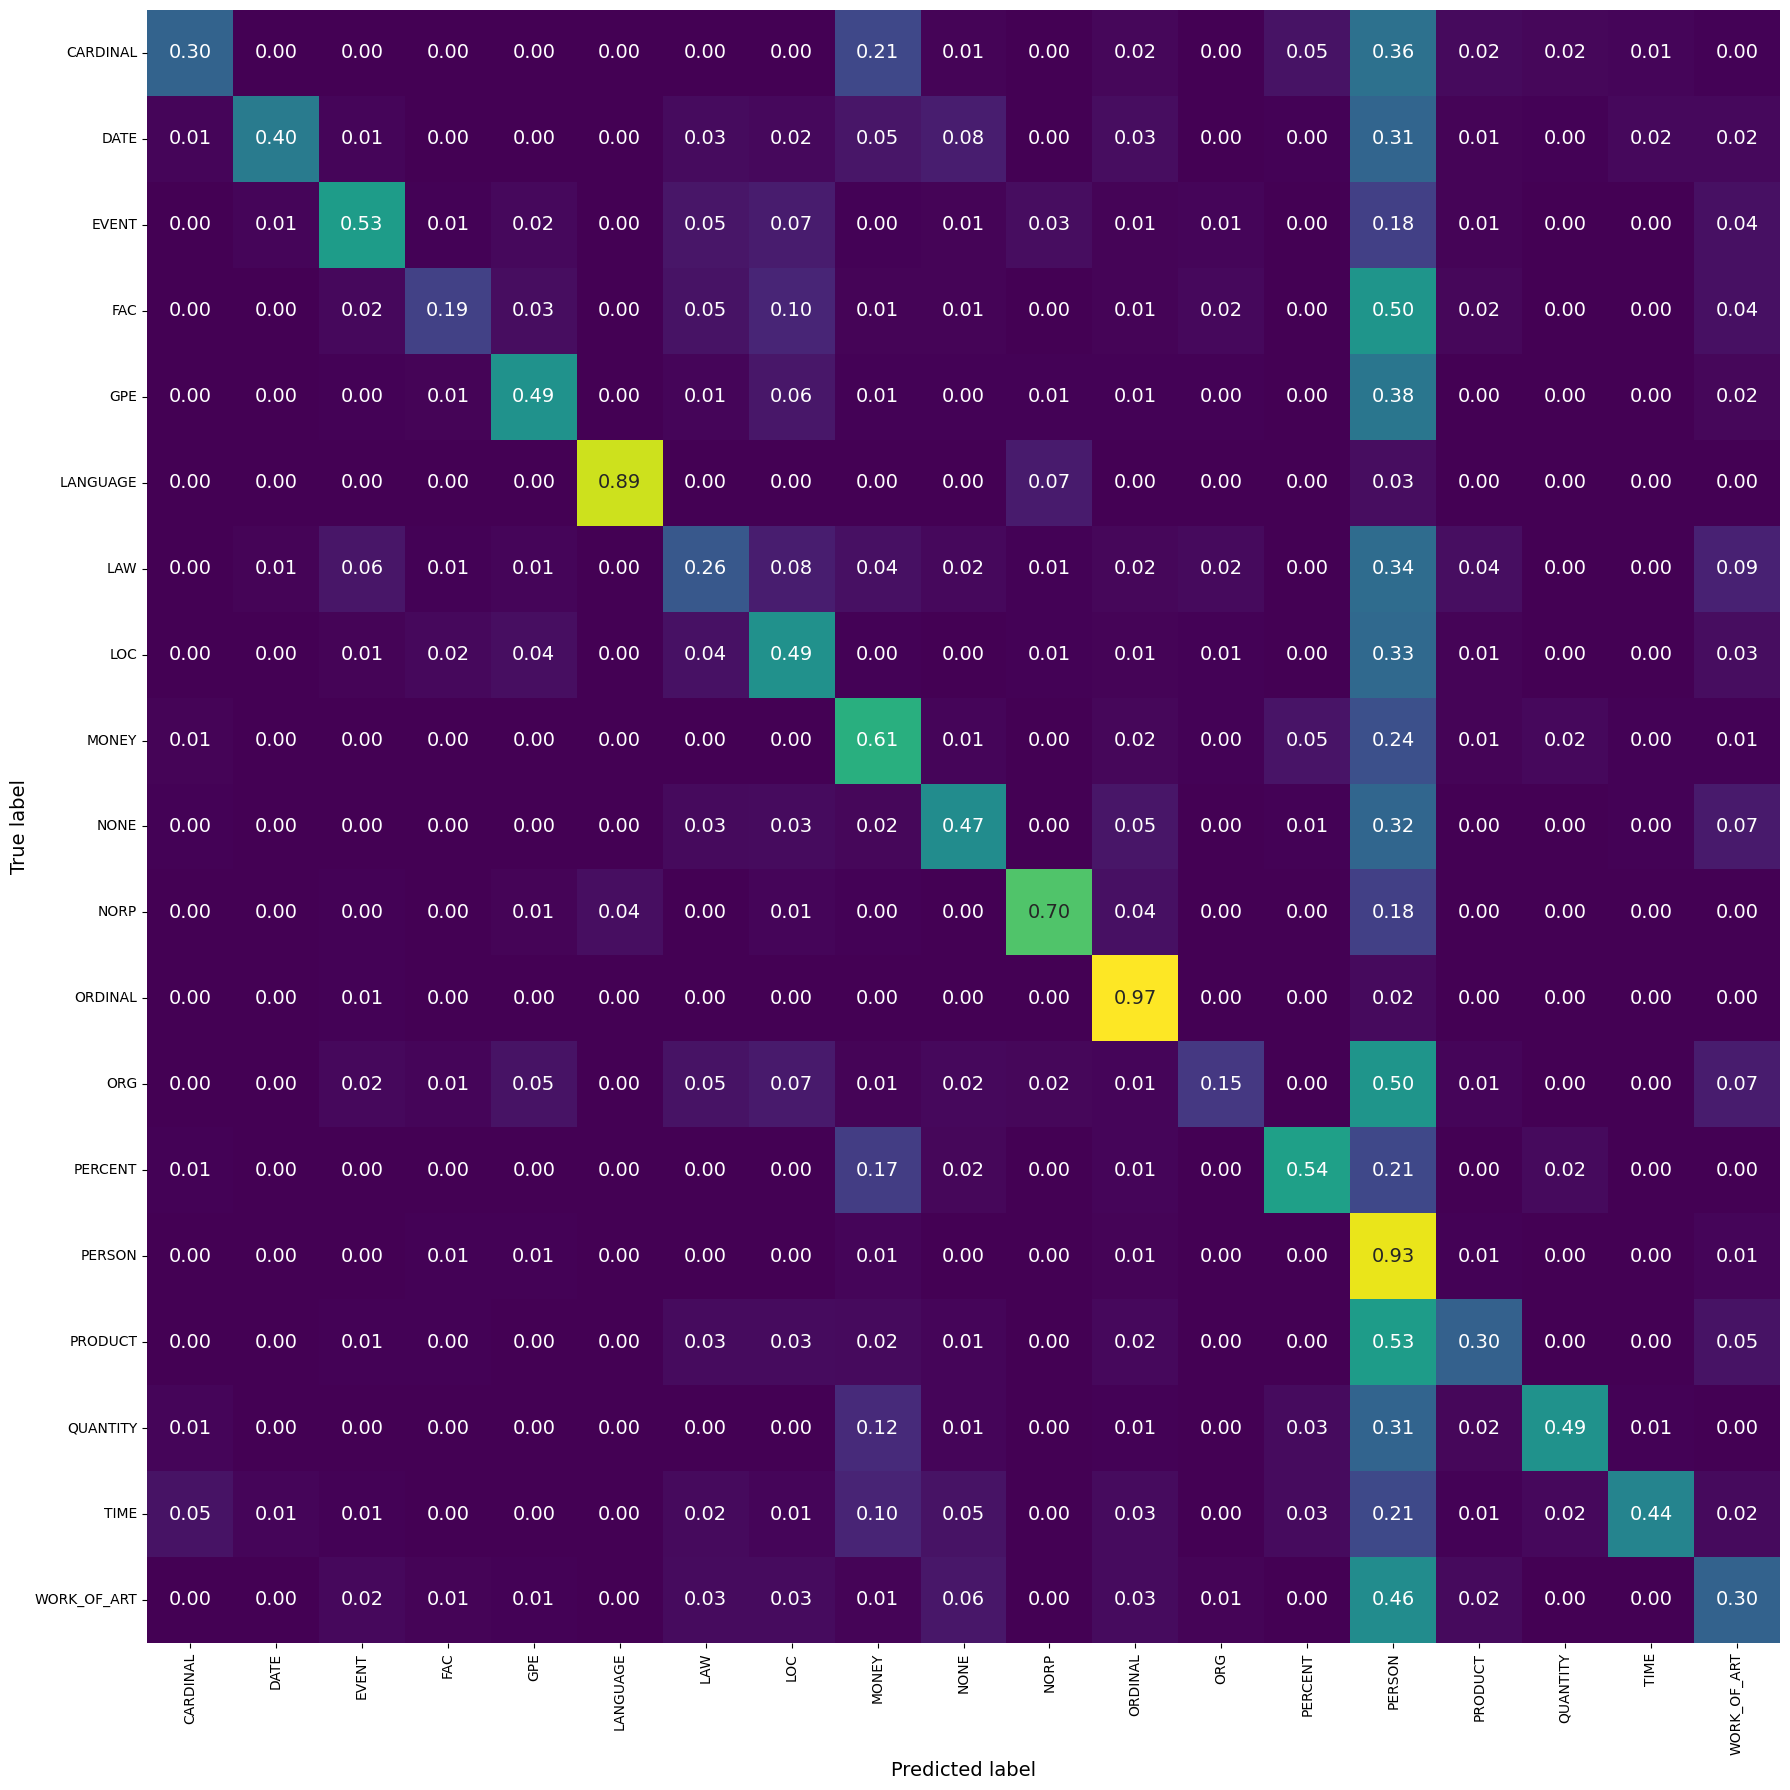

In [17]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [18]:
features = dict_vec.get_feature_names_out()
columns = ordinal_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

In [20]:
ordinal_mappings['ner_tag']

array(['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW',
       'LOC', 'MONEY', 'NONE', 'NORP', 'ORDINAL', 'ORG', 'PERCENT',
       'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART'],
      dtype=object)

In [21]:
explain_df.loc['pos']

CARDINAL       0.008244
DATE           0.008196
EVENT          0.009941
FAC            0.009889
GPE            0.010289
LANGUAGE       0.007895
LAW            0.009217
LOC            0.009884
MONEY          0.008521
NONE           0.008626
NORP           0.006504
ORDINAL        0.003751
ORG            0.009830
PERCENT        0.007945
PERSON         0.010590
PRODUCT        0.009880
QUANTITY       0.008764
TIME           0.007875
WORK_OF_ART    0.009344
Name: pos, dtype: float64

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [22]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001574
EVENT          0.000755
GPE            0.000600
FAC            0.000379
PERSON         0.000297
NONE           0.000059
ORDINAL        0.000000
TIME           0.000000
QUANTITY       0.000000
PRODUCT        0.000000
PERCENT        0.000000
CARDINAL       0.000000
NORP           0.000000
DATE           0.000000
MONEY          0.000000
LOC            0.000000
LAW            0.000000
LANGUAGE       0.000000
WORK_OF_ART    0.000000
Name: token=EU, dtype: float64

In [23]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.229178
token=Arabic        0.054171
token=Hebrew        0.050821
token=Filipino      0.034732
token=Spanish       0.034217
token=French        0.033876
token=Latin         0.024630
token=Russian       0.015815
token=Chinese       0.013724
token=Mandarin      0.012732
token=Cantonese     0.012348
token=Portuguese    0.011517
token=German        0.011476
token=Japanese      0.009290
pos                 0.007895
Name: LANGUAGE, dtype: float64